In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn missingno plotly folium  xgboost catboost lightgbm tensorflow keras


In [2]:
pip install --user sort-dataframeby-monthorweek sorted-months-weekdays


Note: you may need to restart the kernel to use updated packages.


In [3]:
# 1. 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
# Plotting style
plt.style.use('fivethirtyeight')

In [7]:
# 2. 📂 Load the Dataset
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
# Handle missing values
df.fillna(0, inplace=True)


In [9]:
# Remove rows where adults, children, and babies are all zero
filter_invalid_guests = (df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)
df = df[~filter_invalid_guests]

In [10]:
# Create a 'total_nights' feature
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [11]:
# Drop less important columns
useless_cols = ['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type', 'booking_changes', 'reservation_status', 'country', 'days_in_waiting_list']
df.drop(useless_cols, axis=1, inplace=True)

In [12]:
# Split categorical and numerical columns
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
num_cols = [col for col in df.columns if df[col].dtype != 'O']

In [13]:
# Handle date columns
cat_df = df[cat_cols].copy()
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])
cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day
cat_df.drop(['reservation_status_date', 'arrival_date_month'], axis=1, inplace=True)


In [14]:
# Encode categorical variables
encoders = {
    'hotel': {'Resort Hotel': 0, 'City Hotel': 1},
    'meal': {'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4},
    'market_segment': {'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3, 'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7},
    'distribution_channel': {'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3, 'GDS': 4},
    'reserved_room_type': {'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6, 'L': 7, 'B': 8},
    'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
    'customer_type': {'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3}
}


In [15]:
for col, mapping in encoders.items():
    cat_df[col] = cat_df[col].map(mapping)

In [16]:
# Prepare numerical features
num_df = df[num_cols].copy()
num_df.drop('is_canceled', axis=1, inplace=True)

In [17]:
# Apply log transformation to skewed features
for col in ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'agent', 'company', 'adr']:
    num_df[col] = np.log1p(num_df[col])

In [18]:
# Final feature set
X = pd.concat([cat_df, num_df], axis=1)
y = df['is_canceled']

In [19]:
# 4. 🏗️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [22]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [23]:
# Helper function to train and evaluate models
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return acc

In [24]:
# Train models
results = {}
results['Logistic Regression'] = evaluate_model(LogisticRegression(), 'Logistic Regression')
results['KNN'] = evaluate_model(KNeighborsClassifier(), 'K-Nearest Neighbors')
results['Decision Tree'] = evaluate_model(DecisionTreeClassifier(), 'Decision Tree')
results['Random Forest'] = evaluate_model(RandomForestClassifier(), 'Random Forest')
results['AdaBoost'] = evaluate_model(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 'AdaBoost')
results['Gradient Boosting'] = evaluate_model(GradientBoostingClassifier(), 'Gradient Boosting')
results['XGBoost'] = evaluate_model(XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=5, n_estimators=180), 'XGBoost')
results['CatBoost'] = evaluate_model(CatBoostClassifier(iterations=100, verbose=0), 'CatBoost')
results['Extra Trees'] = evaluate_model(ExtraTreesClassifier(), 'Extra Trees')
results['LGBM'] = evaluate_model(LGBMClassifier(learning_rate=1), 'LGBM')


Model: Logistic Regression
Accuracy: 0.7740122472946901
Confusion Matrix:
 [[20288  2173]
 [ 5909  7393]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83     22461
           1       0.77      0.56      0.65     13302

    accuracy                           0.77     35763
   macro avg       0.77      0.73      0.74     35763
weighted avg       0.77      0.77      0.76     35763


Model: K-Nearest Neighbors
Accuracy: 0.885440259486061
Confusion Matrix:
 [[21617   844]
 [ 3253 10049]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     22461
           1       0.92      0.76      0.83     13302

    accuracy                           0.89     35763
   macro avg       0.90      0.86      0.87     35763
weighted avg       0.89      0.89      0.88     35763


Model: Decision Tree
Accuracy: 0.9511785923999665
Confusion Matrix:
 [[21553   908]


In [27]:
# Voting Classifier
voting = VotingClassifier(estimators=[
    ('gb', GradientBoostingClassifier()),
    ('cat', CatBoostClassifier(iterations=100, verbose=0)),
    ('xgb', XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=5, n_estimators=180))
])
results['Voting Classifier'] = evaluate_model(voting, 'Voting Classifier')


Model: Voting Classifier
Accuracy: 0.9836423118865867
Confusion Matrix:
 [[22452     9]
 [  576 12726]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     22461
           1       1.00      0.96      0.98     13302

    accuracy                           0.98     35763
   macro avg       0.99      0.98      0.98     35763
weighted avg       0.98      0.98      0.98     35763



In [28]:
# 6. 🧠 ANN Model
ann = Sequential()
ann.add(Dense(100, activation='relu', input_dim=X.shape[1]))
ann.add(Dense(100, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=50, batch_size=128, verbose=0)

In [29]:
# Evaluate ANN
loss, acc = ann.evaluate(X_test, y_test)
print("\nANN Model Accuracy:", acc)
results['ANN'] = acc

1118/1118 [==============================] - 1s 1ms/step - loss: 0.4082 - accuracy: 0.8191

ANN Model Accuracy: 0.8190867900848389


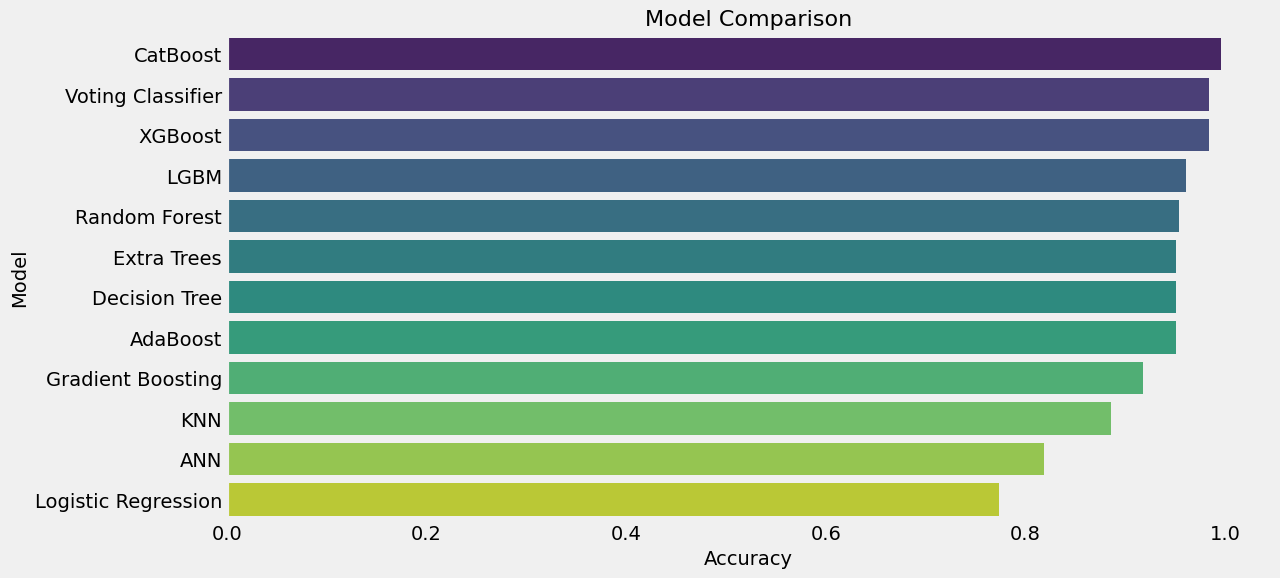

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Model Comparison with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Comparison', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(axis='x')
plt.show()


In [31]:
# 8. ✅ Conclusion
print("\nHighest accuracy achieved by:", results_df.iloc[0]['Model'], "with Accuracy:", results_df.iloc[0]['Accuracy'])


Highest accuracy achieved by: CatBoost with Accuracy: 0.9961133014568129
